# Logistic Regression with UCI Dataset

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

from ld import LD, BP, get_eta, compute_Q, block_B

In [2]:
def find_factorization(D):
    factors = []

    # Try to find a factorization with 3 factors first
    for a in range(2, int(D**(1/3)) + 2):
        if D % a == 0:
            bc = D // a
            for b in range(a, int(bc**(1/2)) + 2):
                if bc % b == 0:
                    c = bc // b
                    factors.append((a, b, c))
                    return factors

    # If 3-factor factorization is not found, try 2-factor factorization
    for a in range(2, int(D**(1/2)) + 2):
        if D % a == 0:
            b = D // a
            factors.append((a, b))
            return factors

    return factors

## Basic Logistic Regression

### Dataset

In [3]:
UCI_id = 53
test_size = 0.5

In [4]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# Normalize the input data
# X_mean = np.mean(X, axis=0)
# X_std = np.std(X, axis=0)
# X = normalization(X, X_mean, X_std)

# Find unique labels
unique_labels = np.unique(Y)
print("Unique labels:", unique_labels)

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
n_train = int(len(Y) * (1 - test_size))
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

print("Shape of features:", X_train.shape)

X_train_class = []
Y_train_class = []
for i in unique_labels:
    X_train_class.append(X_train[np.isin(Y_train, i).flatten()])
    Y_train_class.append(Y_train[np.isin(Y_train, i).flatten()])

Shape of features: (150, 4)
Shape of labels: (150,)
Unique labels: [0 1 2]
Shape of features: (75, 4)


In [5]:
# Feature dimension
D = X_train.shape[1]

D_ = find_factorization(D)[0]
# D_ = (3, 5, 2)
print("Tensor Structure of the Feature:", D_)

Tensor Structure of the Feature: (2, 2, 1)


Accuracy on the test set: 0.9733333333333334


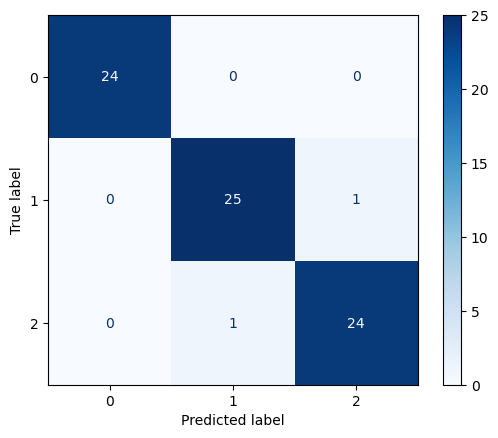

In [6]:
# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, Y_train)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Data Generation

### Legendre Decomposition

In [7]:
scaleX_class = []
theta_class = []

for X_train_per_class in X_train_class:
    scaleX_list = []
    theta_list = []

    for x in X_train_per_class:
        x_tensor = x.reshape(*D_)
        _, scaleX, Q, theta = LD(x_tensor, order=2, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
        scaleX_list.append(scaleX)
        theta_list.append(theta)

    scaleX_class.append(scaleX_list)
    theta_class.append(theta_list)

### Fitting and Sampling

In [8]:
from sklearn.neighbors import KernelDensity

num_new_samples = 200

sampled_Q_class = []
sampled_theta_class = []

for i in unique_labels:
    theta = np.array(theta_class[i]).reshape(-1, D)
    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(theta.reshape(theta.shape[0], -1))
    # Sample new data from the KDE
    sampled_theta = (kde.sample(n_samples=num_new_samples)).reshape(num_new_samples, *D_)

    sampled_Q = np.array([compute_Q(sampled_theta[j]) for j in range(num_new_samples)])

    sampled_theta_class.append(sampled_theta)
    sampled_Q_class.append(sampled_Q)

#### Construct Submanifold

In [9]:
# Construct the constrained coordinates
B = block_B([1, 1, 0], [2, 2, 1])

print("B:", B)

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_class = []

for i in unique_labels:
    eta_hat_list = []
    for j in range(X_train_class[i].shape[0]):
        x_tensor = X_train_class[i][j].reshape(*D_)
        eps = np.asarray(1.0e-5)
        xp = cp.get_array_module(x_tensor)
        P = (x_tensor + eps) / scaleX_class[i][j]
        eta_hat = get_eta(P, len(D_), xp)
        eta_hat_list.append(eta_hat)
    eta_hat_list = cp.asarray(eta_hat_list)

    eta_hat_class.append(eta_hat_list)

B: [[1 1 0]]


#### Backward Projection

In [10]:
def find_closest_datapoint(input_point, training_data):
    min_distance = float('inf')
    closest_index = -1
    for i, data_point in enumerate(training_data):
        euclidean_distance = np.sqrt(np.sum((np.array(input_point) - np.array(data_point)) ** 2))
        if euclidean_distance < min_distance:
            min_distance = euclidean_distance
            closest_index = i
    return closest_index

sampled_P_BP_class = []
sampled_theta_BP_class = []
X_recons_class = []

for i in unique_labels:
    sampled_P_list_BP = []
    sampled_theta_list_BP = []
    X_recons_list = []

    for j in range(num_new_samples):
        k = find_closest_datapoint(sampled_theta_class[i][j].reshape(-1), np.array(theta_class[i]).reshape(len(theta_class[i]), -1))

        _, P, theta = BP(sampled_Q_class[i][j], sampled_theta_class[i][j], eta_hat_class[i][k], scaleX_class[i][k], B=B, verbose=False)
        sampled_P_list_BP.append(P)
        sampled_theta_list_BP.append(theta)

        X_recons = (P).astype(np.int32).reshape(-1)
        X_recons_list.append(X_recons)

    sampled_P_BP_class.append(sampled_P_list_BP)
    sampled_theta_BP_class.append(sampled_theta_list_BP)
    X_recons_class.append(np.array(X_recons_list))

## Generated Data Quality

### Trained on Generated Data

Accuracy on the test set: 0.9466666666666667


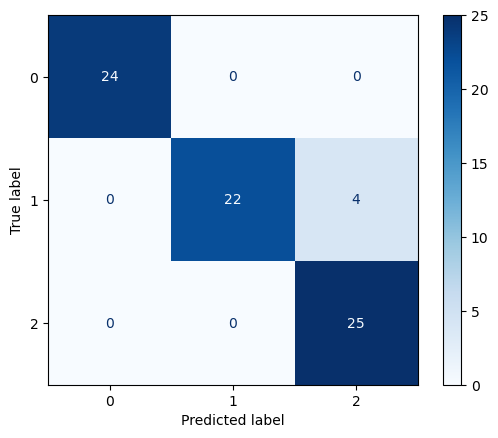

In [11]:
# Initialize lists to hold new samples
X_train_list_new = []
Y_train_list_new = []

for i in unique_labels:
    X_train_list_new.append(X_recons_class[i])
    Y_train_list_new.append([i] * num_new_samples)

# Convert lists to numpy arrays
X_train_new = np.concatenate(X_train_list_new, axis=0)
Y_train_new = np.concatenate(Y_train_list_new, axis=0)

# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_new, Y_train_new)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Visualization

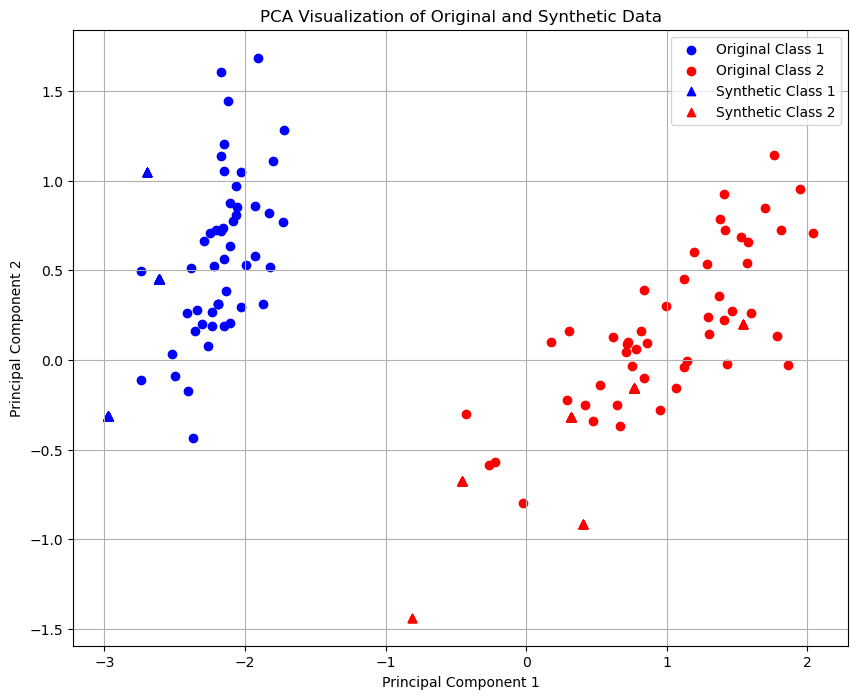

In [12]:
from sklearn.decomposition import PCA

# Generate original data (example)
X_original, Y_original = X, Y

# Generate synthetic data for class 1 and class 2 (example)
X_synthetic, Y_synthetic = X_train_new, Y_train_new

# Step 1: Perform PCA for dimensionality reduction on original data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.concatenate((X_original, X_synthetic)))

# Step 3: Plotting
plt.figure(figsize=(10, 8))

# Plot original data
plt.scatter(X_pca[:X_original.shape[0]][Y_original == 0, 0], X_pca[:X_original.shape[0]][Y_original == 0, 1], color='b', marker='o', label='Original Class 1')
plt.scatter(X_pca[:X_original.shape[0]][Y_original == 1, 0], X_pca[:X_original.shape[0]][Y_original == 1, 1], color='r', marker='o', label='Original Class 2')
# plt.scatter(X_pca[:X_original.shape[0]][Y_original == 2, 0], X_pca[:X_original.shape[0]][Y_original == 2, 1], color='g', marker='o', label='Original Class 3')
plt.scatter(X_pca[X_original.shape[0]:][Y_synthetic == 0, 0], X_pca[X_original.shape[0]:][Y_synthetic == 0, 1], color='b', marker='^', label='Synthetic Class 1')
plt.scatter(X_pca[X_original.shape[0]:][Y_synthetic == 1, 0], X_pca[X_original.shape[0]:][Y_synthetic == 1, 1], color='r', marker='^', label='Synthetic Class 2')
# plt.scatter(X_pca[X_original.shape[0]:][Y_synthetic == 2, 0], X_pca[X_original.shape[0]:][Y_synthetic == 2, 1], color='g', marker='^', label='Synthetic Class 3')

plt.title('PCA Visualization of Original and Synthetic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
